In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rania121","key":"214a81c41cafd2a04cf2b029606405a5"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -drashikrahmanpritom/plant-disease-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset
License(s): CC0-1.0
 98% 1.22G/1.25G [00:08<00:00, 236MB/s]
100% 1.25G/1.25G [00:08<00:00, 154MB/s]


In [4]:
!unzip plant-disease-recognition-dataset.zip

Archive:  plant-disease-recognition-dataset.zip
  inflating: Test/Test/Healthy/8ddaa5a5caa5caa8.jpg  
  inflating: Test/Test/Healthy/8ddaac1bd6c8cd0a.jpg  
  inflating: Test/Test/Healthy/8ddd5ec1c0de38c4.jpg  
  inflating: Test/Test/Healthy/8def3f60308ab41b.jpg  
  inflating: Test/Test/Healthy/8def4d91382175c3.jpg  
  inflating: Test/Test/Healthy/8df452e2e38c0b6e.jpg  
  inflating: Test/Test/Healthy/8dfae9d78cc32089.jpg  
  inflating: Test/Test/Healthy/8e3dbccdfe08c850.jpg  
  inflating: Test/Test/Healthy/8e68163c62dc57d5.jpg  
  inflating: Test/Test/Healthy/8e6a823cce9ff40c.jpg  
  inflating: Test/Test/Healthy/8e77857194a59a87.jpg  
  inflating: Test/Test/Healthy/8e79802b3fb770c8.jpg  
  inflating: Test/Test/Healthy/8e7986d1ecd36445.jpg  
  inflating: Test/Test/Healthy/8e7e70a6878c1c79.jpg  
  inflating: Test/Test/Healthy/8e82b1a51bd11afe.jpg  
  inflating: Test/Test/Healthy/8e8470687be37378.jpg  
  inflating: Test/Test/Healthy/8e858c8397706b7b.jpg  
  inflating: Test/Test/Healthy/8e8

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import random
import cv2
import shutil
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, DenseNet201, MobileNetV2
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [6]:
def count_images(base_path):
    print(f"{base_path}")
    classes = os.listdir(base_path)
    for cls in classes:
        class_path = os.path.join(base_path, cls)
        if os.path.isdir(class_path):
            count = len([
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.jpg', '.png', '.jpeg'))
            ])
            print(f"{cls} : {count} images")

count_images("Train/Train")
count_images("Validation/Validation")
count_images("Test/Test")


Train/Train
Powdery : 430 images
Healthy : 458 images
Rust : 434 images
Validation/Validation
Powdery : 20 images
Healthy : 20 images
Rust : 20 images
Test/Test
Powdery : 50 images
Healthy : 50 images
Rust : 50 images



Showing random images from: Train


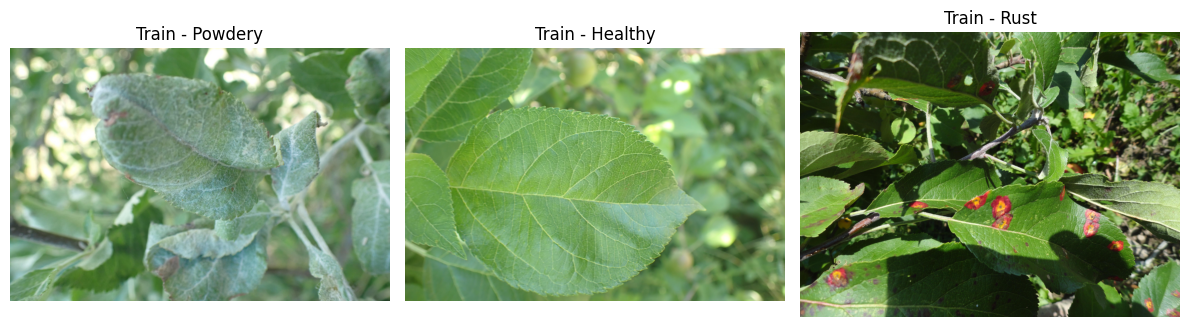


Showing random images from: Validation


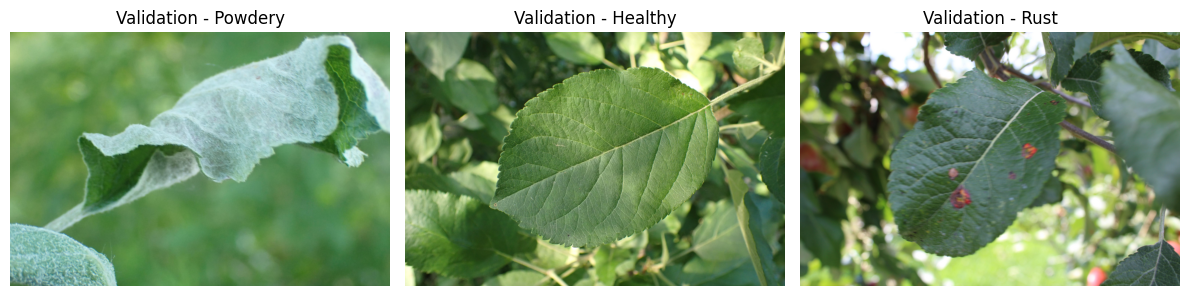


Showing random images from: Test


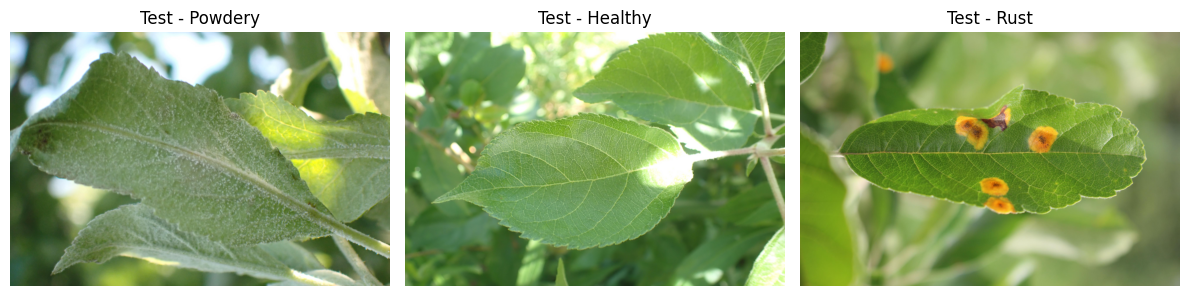

In [7]:
def show_random_images(base_dir, title):
    print(f"\nShowing random images from: {title}")
    categories = os.listdir(base_dir)

    plt.figure(figsize=(12, 4))

    for i, category in enumerate(categories):
        category_path = os.path.join(base_dir, category)
        if os.path.isdir(category_path):
            image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if image_files:
                random_img = random.choice(image_files)
                img_path = os.path.join(category_path, random_img)
                img = mpimg.imread(img_path)

                plt.subplot(1, 3, i+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"{title} - {category}")

    plt.tight_layout()
    plt.show()

show_random_images("Train/Train", "Train")
show_random_images("Validation/Validation", "Validation")
show_random_images("Test/Test", "Test")


In [8]:
base_dirs = ["Train/Train", "Validation/Validation", "Test/Test"]
output_dir = "all_data"
classes = ["Healthy", "Rust", "Powdery"]

for cls in classes:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

for base in base_dirs:
    for cls in classes:
        source_dir = os.path.join(base, cls)
        dest_dir = os.path.join(output_dir, cls)
        for img in os.listdir(source_dir):
            src_path = os.path.join(source_dir, img)
            dst_path = os.path.join(dest_dir, img)
            shutil.copy(src_path, dst_path)


In [9]:
base_dir = "all_data"
output_dir = "new_split"
classes = ["Healthy", "Rust", "Powdery"]

for split in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

    train_val, test = train_test_split(images, test_size=0.15, random_state=42)
    train, val = train_test_split(train_val, test_size=0.176, random_state=42)

    for split_name, split_data in zip(["train", "val", "test"], [train, val, test]):
        for img_path in split_data:
            dest = os.path.join(output_dir, split_name, cls, os.path.basename(img_path))
            shutil.copy(img_path, dest)


In [10]:
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'new_split/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    'new_split/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    'new_split/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1071 images belonging to 3 classes.
Found 230 images belonging to 3 classes.
Found 231 images belonging to 3 classes.


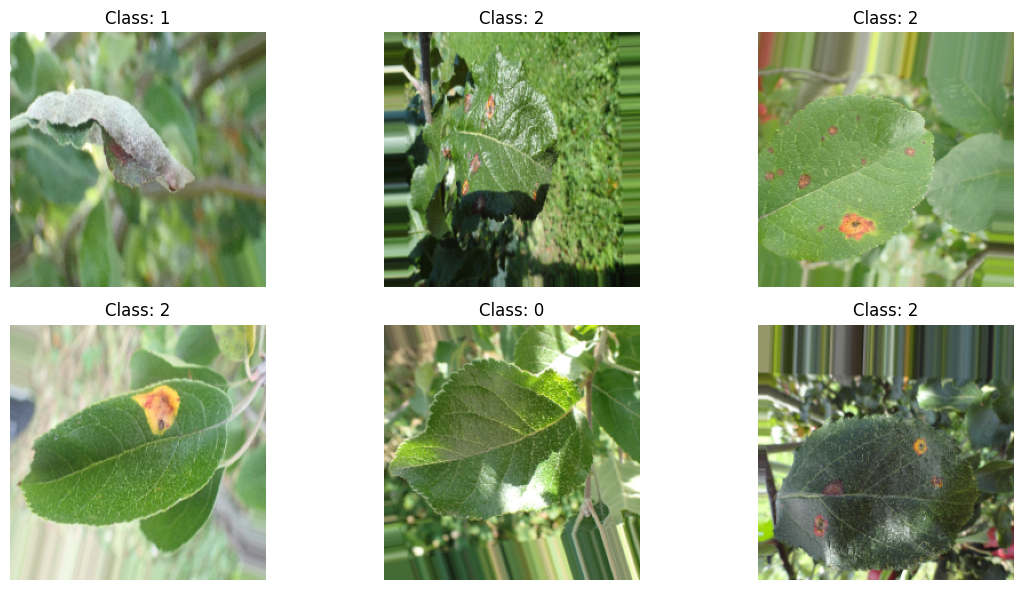

In [11]:
images, labels = next(train_generator)

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Class: {np.argmax(labels[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## **CNN Costum**

In [42]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, validation_data=val_generator, epochs=15, verbose=1)


Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.3893 - loss: 1.6120 - val_accuracy: 0.6348 - val_loss: 0.7150
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5444 - loss: 0.8469 - val_accuracy: 0.7087 - val_loss: 0.6987
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.6283 - loss: 0.7820 - val_accuracy: 0.6609 - val_loss: 0.7006
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6569 - loss: 0.6982 - val_accuracy: 0.6826 - val_loss: 0.7420
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6947 - loss: 0.7137 - val_accuracy: 0.8261 - val_loss: 0.4365
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7873 - loss: 0.5351 - val_accuracy: 0.7000 - val_loss: 0.6837
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7225 - loss: 0.6725 - val_accuracy: 0.8304 - val_loss: 0.4233
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8511 - loss: 0.4673 - val_accuracy: 0.9304 - val_loss:

In [44]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9396 - loss: 0.2085
Test Accuracy: 0.91
Test Loss: 0.2790


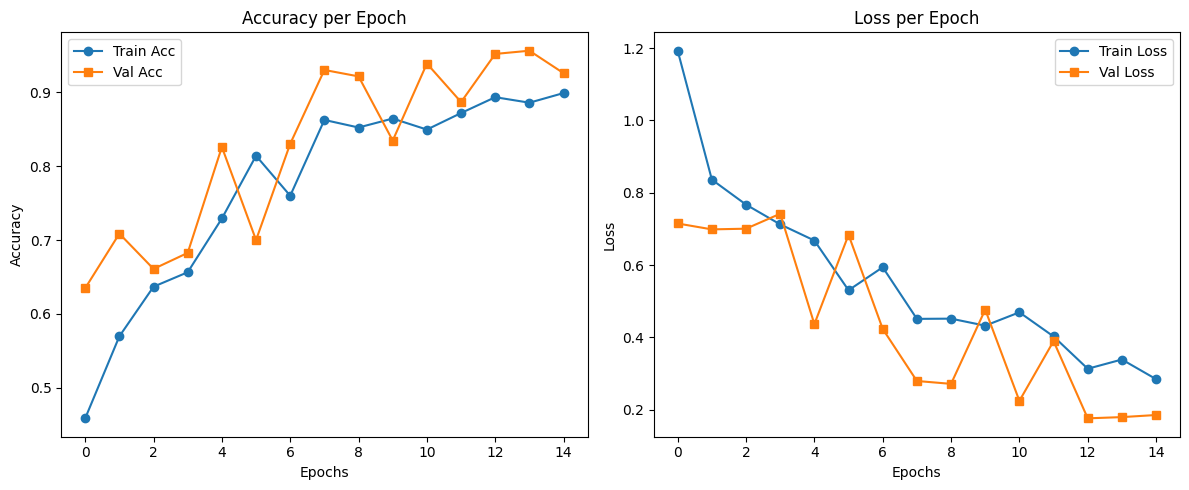

In [45]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='s')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='s')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [46]:
test_generator.reset()
y_probs = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(y_probs, axis=1)
y_true = test_generator.classes

print("y_true:", len(y_true))
print("y_pred:", len(y_pred))


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
y_true: 231
y_pred: 231


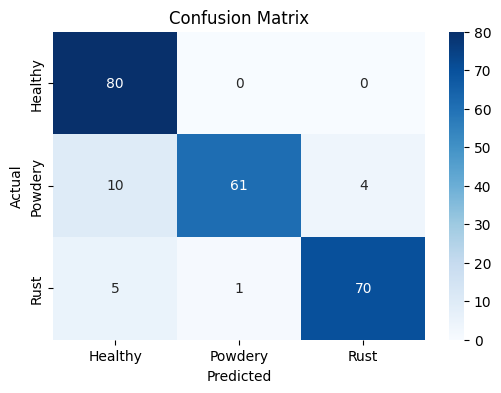

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.84      1.00      0.91        80
     Powdery       0.98      0.81      0.89        75
        Rust       0.95      0.92      0.93        76

    accuracy                           0.91       231
   macro avg       0.92      0.91      0.91       231
weighted avg       0.92      0.91      0.91       231



In [47]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


## **VGG16**

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model2 = Sequential([
            base_model,
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(3, activation='softmax')
        ])
model2.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,979 (68.39 MB)

 Trainable params: 3,212,035 (12.25 MB)

 Non-trainable params: 14,714,944 (56.13 MB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_VGG16 = model2.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks=[early_stop])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.6313 - loss: 1.0404 - val_accuracy: 0.6565 - val_loss: 1.1461
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7663 - loss: 0.5653 - val_accuracy: 0.7130 - val_loss: 0.8045
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8310 - loss: 0.4073 - val_accuracy: 0.8696 - val_loss: 0.3462
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8668 - loss: 0.3698 - val_accuracy: 0.8696 - val_loss: 0.2688
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8695 - loss: 0.3196 - val_accuracy: 0.9043 - val_loss: 0.2268
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8887 - loss: 0.3246 - val_accuracy: 0.8652 - val_loss: 0.3519
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9030 - loss: 0.2795 - val_accuracy: 0.8652 - val_loss: 0.2885
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8731 - loss: 0.3276 - val_accuracy: 0.9348 - val_loss:

In [ ]:
test_loss, test_acc = model2.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9206 - loss: 0.2526
Test Accuracy: 0.91
Test Loss: 0.2544


In [ ]:
y_probs2 = model2.predict(test_generator)
y_pred2 = np.argmax(y_probs2, axis=1)
y_true2 = test_generator.classes


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


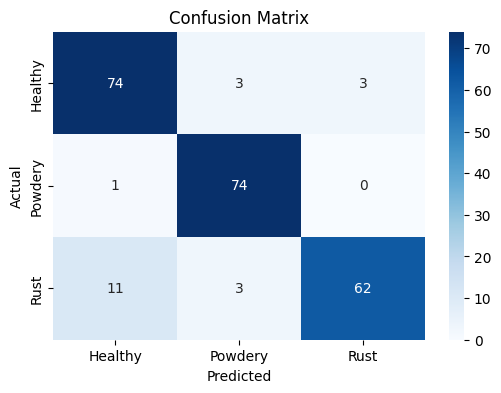

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.86      0.93      0.89        80
     Powdery       0.93      0.99      0.95        75
        Rust       0.95      0.82      0.88        76

    accuracy                           0.91       231
   macro avg       0.91      0.91      0.91       231
weighted avg       0.91      0.91      0.91       231



In [ ]:
cm = confusion_matrix(y_true2, y_pred2)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true2, y_pred2, target_names=test_generator.class_indices.keys()))

## **MobileNetV2**

In [35]:
base_model2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model2.layers:
    layer.trainable = False


model3 = Sequential([
            base_model2,
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(3, activation='softmax')
        ])
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,286,659 (39.24 MB)

 Trainable params: 8,028,675 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [36]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_MobileNetV2 = model3.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks=[early_stop])


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.6145 - loss: 6.0041 - val_accuracy: 0.9348 - val_loss: 0.2574
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.8389 - loss: 0.3945 - val_accuracy: 0.9391 - val_loss: 0.2392
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.8058 - loss: 0.5651 - val_accuracy: 0.9609 - val_loss: 0.1646
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.8755 - loss: 0.3508 - val_accuracy: 0.9391 - val_loss: 0.1953
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8649 - loss: 0.3294 - val_accuracy: 0.9261 - val_loss: 0.3104
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9034 - loss: 0.2931 - val_accuracy: 0.9652 - val_loss: 0.2169


In [37]:
test_loss, test_acc = model3.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9610 - loss: 0.1489
Test Accuracy: 0.97
Test Loss: 0.1283


In [38]:
y_probs3 = model3.predict(test_generator)
y_pred3 = np.argmax(y_probs3, axis=1)
y_true3 = test_generator.classes


8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


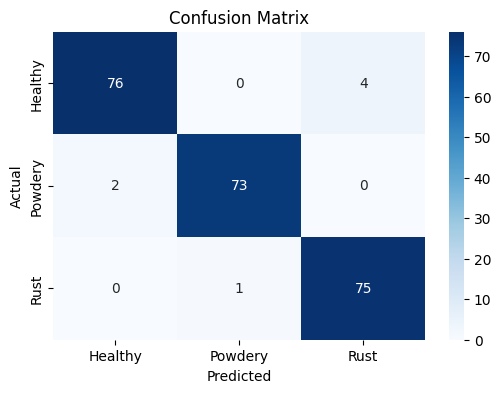

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.97      0.95      0.96        80
     Powdery       0.99      0.97      0.98        75
        Rust       0.95      0.99      0.97        76

    accuracy                           0.97       231
   macro avg       0.97      0.97      0.97       231
weighted avg       0.97      0.97      0.97       231



In [39]:
cm = confusion_matrix(y_true3, y_pred3)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true3, y_pred3, target_names=test_generator.class_indices.keys()))

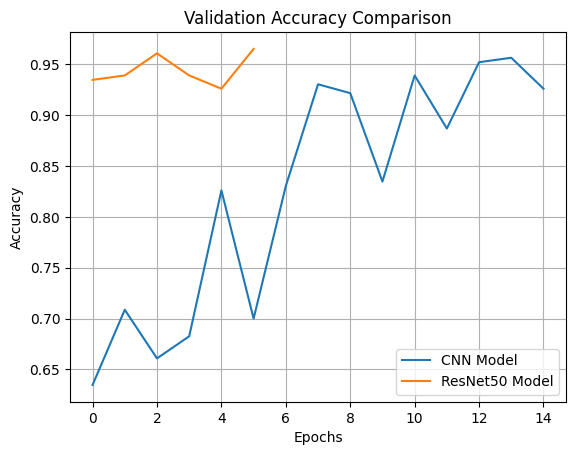

In [48]:
plt.plot(history.history['val_accuracy'], label='CNN Model')
plt.plot(history_MobileNetV2.history['val_accuracy'], label='ResNet50 Model')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
